In [ ]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np
import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf
print ("Done")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


# preprocessing

# Importing Data

                                              Ravdess Dataframe
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [ ]:
#preparing data set

ravdess = "/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_20', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_22', 'Actor_23', 'Actor_21', 'Actor_15', 'Actor_24', 'Actor_16', 'Actor_10', 'Actor_09', 'Actor_07', 'Actor_06', 'Actor_05', 'Actor_08', 'Actor_13', 'Actor_11', 'Actor_14', 'Actor_12', 'Actor_01', 'Actor_02', 'Actor_04', 'Actor_03']


**Ravdees**

In [ ]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)


In [ ]:
print(actor[0])
print(part[0])
print(file_path[0])
print(int(part[2]))
print(f)

03-01-01-01-02-01-03.wav
03
/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/Actor_20/03-01-01-01-01-02-20.wav
8
03-01-08-01-02-01-03.wav


In [ ]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())



  Emotions                                               Path
0  neutral  /content/drive/MyDrive/speech-emotion-recognit...
1  neutral  /content/drive/MyDrive/speech-emotion-recognit...
2    happy  /content/drive/MyDrive/speech-emotion-recognit...
3    happy  /content/drive/MyDrive/speech-emotion-recognit...
4  neutral  /content/drive/MyDrive/speech-emotion-recognit...
______________________________________________
      Emotions                                               Path
1435  surprise  /content/drive/MyDrive/speech-emotion-recognit...
1436   disgust  /content/drive/MyDrive/speech-emotion-recognit...
1437   disgust  /content/drive/MyDrive/speech-emotion-recognit...
1438  surprise  /content/drive/MyDrive/speech-emotion-recognit...
1439  surprise  /content/drive/MyDrive/speech-emotion-recognit...
_______________________________________________
Emotions
neutral     288
happy       192
sad         192
disgust     192
fear        192
angry       192
surprise    192
Name: count, dty

**Integration**

In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,/content/drive/MyDrive/speech-emotion-recognit...
1,neutral,/content/drive/MyDrive/speech-emotion-recognit...
2,happy,/content/drive/MyDrive/speech-emotion-recognit...
3,happy,/content/drive/MyDrive/speech-emotion-recognit...
4,neutral,/content/drive/MyDrive/speech-emotion-recognit...


In [ ]:
print(data_path.Emotions.value_counts())


Emotions
neutral     288
happy       192
sad         192
disgust     192
fear        192
angry       192
surprise    192
Name: count, dtype: int64


In [ ]:
data_path.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotions  1440 non-null   object
 1   Path      1440 non-null   object
dtypes: object(2)
memory usage: 22.6+ KB


>*                           Data Visualisation and Exploration

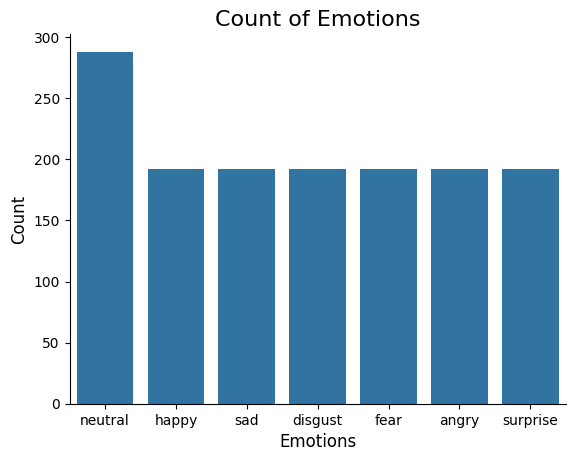

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(x=data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
data,sr = librosa.load(file_path[0])
sr

22050

In [ ]:
ipd.Audio(data,rate=sr)

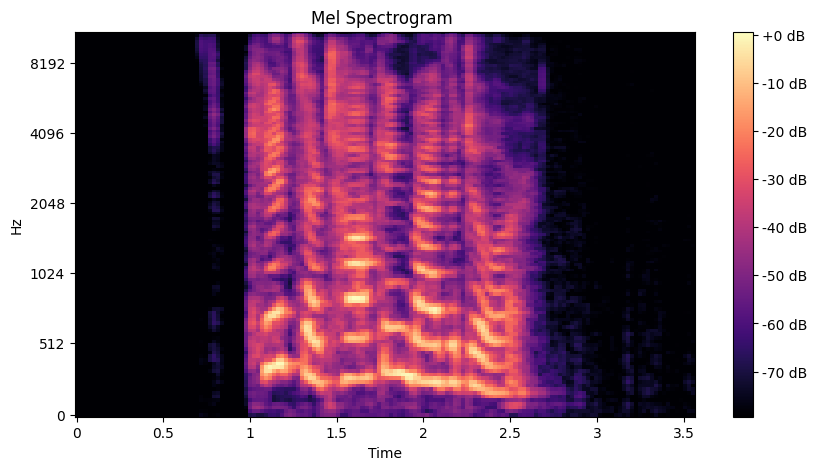

In [ ]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

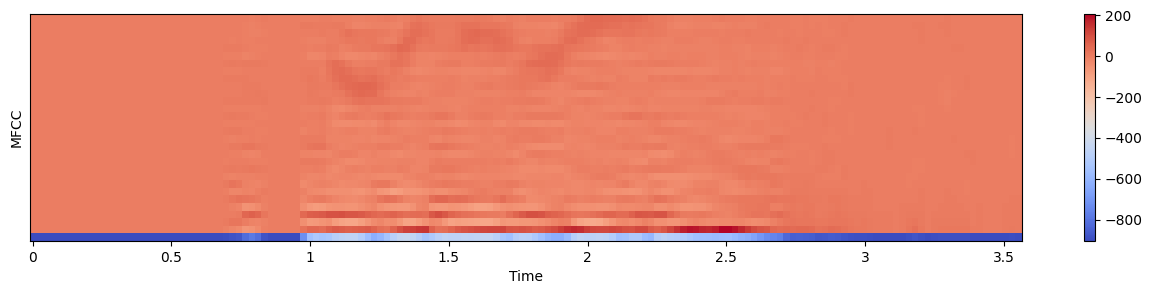

In [ ]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

# Data augmentation

In [ ]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, n_steps=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate,  n_steps=0.7)


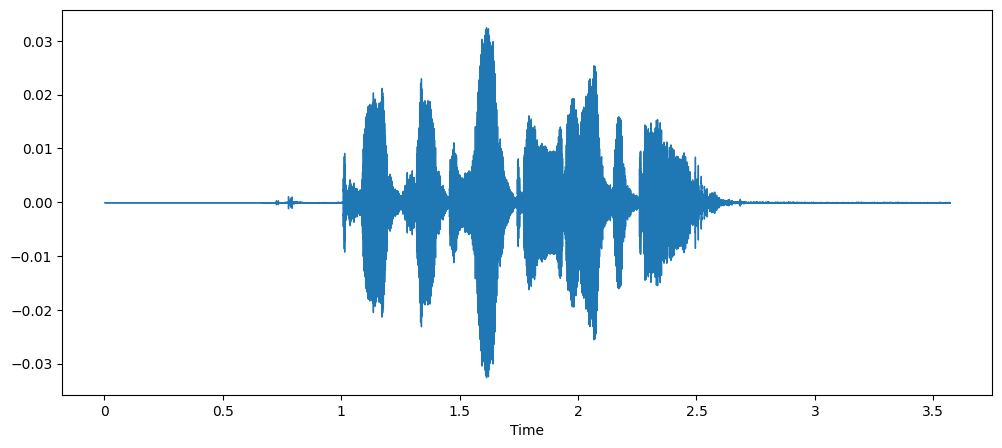

In [ ]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

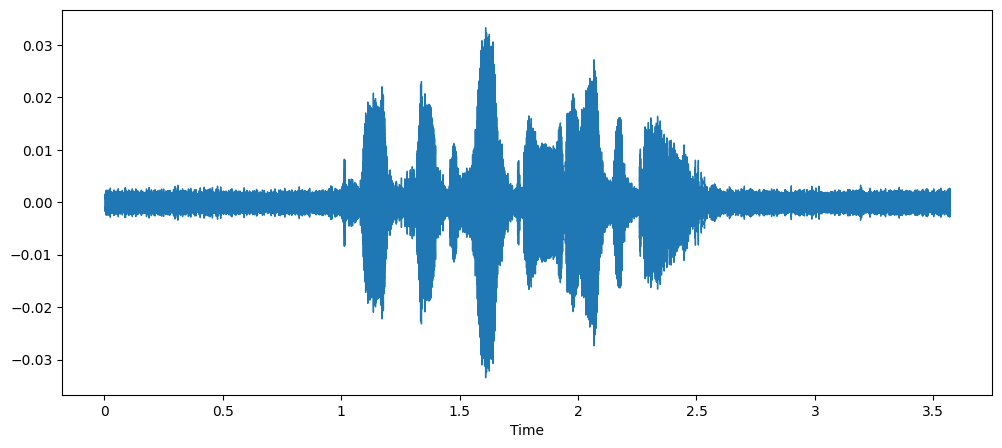

In [ ]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

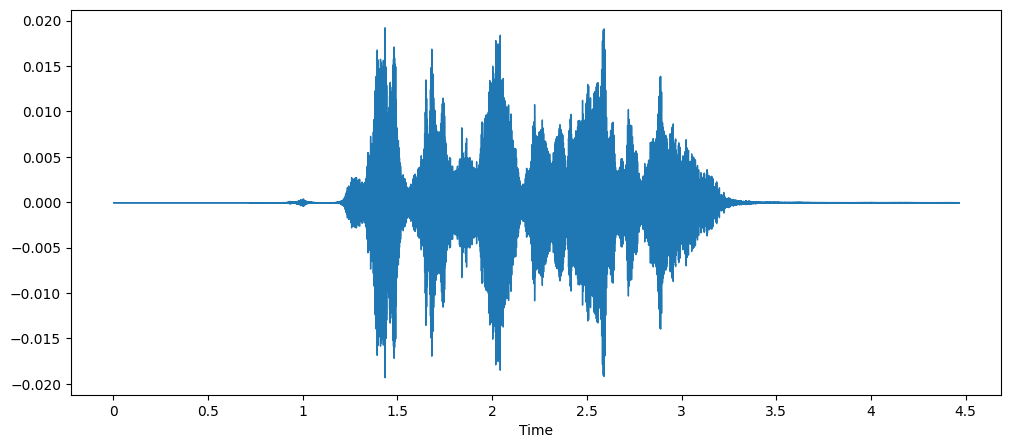

In [ ]:
# STRETCHED AUDIO
x = librosa.effects.time_stretch(data, rate=0.8)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

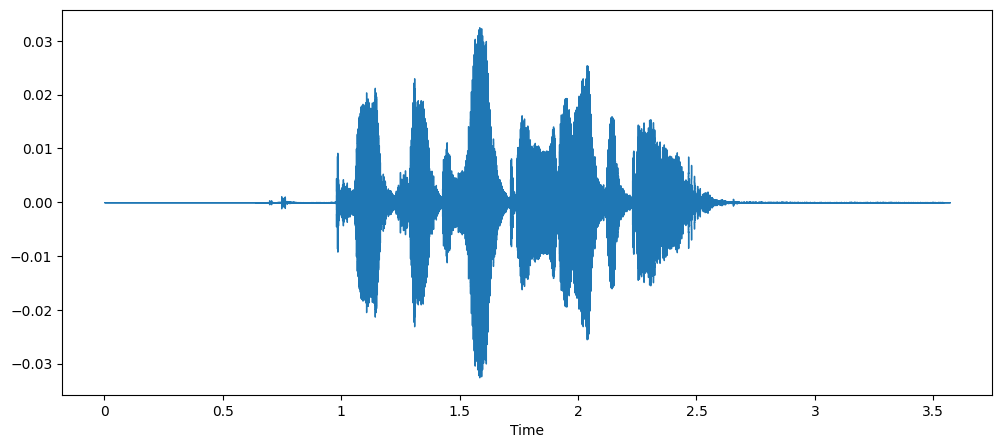

In [ ]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

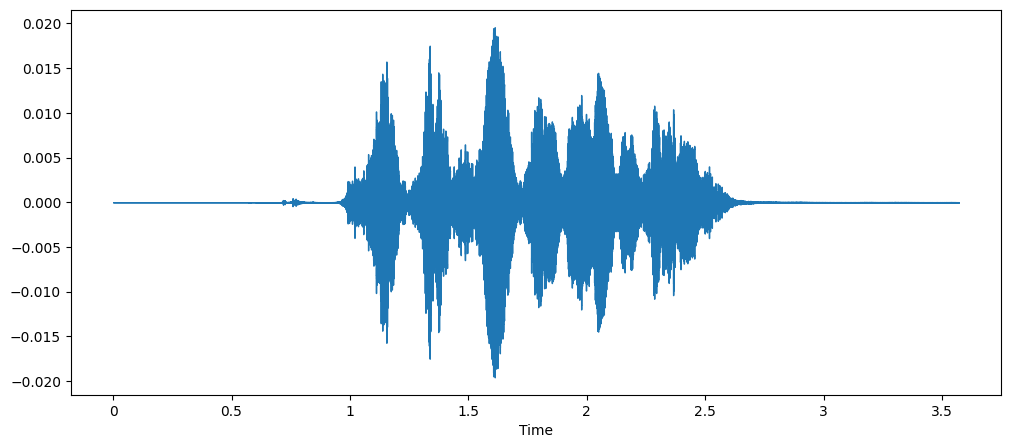

In [ ]:
# AUDIO WITH PITCH
x = librosa.effects.pitch_shift(data, sr=sr,n_steps=4)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature extraction

In [ ]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data):
    rmse=librosa.feature.rms(y=data)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio


In [ ]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


In [ ]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

1it [00:00,  5.56it/s]

0 audio has been processed


501it [04:03,  2.35it/s]

500 audio has been processed


1001it [08:07,  2.08it/s]

1000 audio has been processed


1440it [11:40,  2.05it/s]

Done
Time:  700.843318898


In [ ]:
len(X), len(Y), data_path.Path.shape


(5760, 5760, (1440,))

# Saving features

In [ ]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.000000,0.000000,0.000000,0.041016,0.208496,0.330566,0.472168,0.536621,0.497070,0.542480,...,1.276496,1.978471,2.222614,1.868164,1.191923,0.650578,0.501740,0.611455,0.611360,neutral
1,0.239258,0.364258,0.486816,0.491699,0.502930,0.503418,0.516113,0.515625,0.501465,0.506836,...,-1.846841,-1.755969,1.649124,-1.016515,-0.930806,1.116495,2.270982,2.559305,-0.936132,neutral
2,0.012695,0.125488,0.226074,0.349609,0.460449,0.467285,0.483887,0.467285,0.450195,0.452148,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral
3,0.262207,0.381348,0.495605,0.492676,0.486816,0.495605,0.502930,0.491699,0.490723,0.484863,...,2.168087,-8.410538,-1.329505,-5.306254,-5.567701,0.497202,0.365026,-2.683326,-3.729541,neutral
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.021943,-0.040387,-0.057805,-0.073756,-0.087832,-0.099693,-0.108993,-0.115542,-0.119152,neutral


In [ ]:
Emotions = pd.read_csv('/content/drive/MyDrive/emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.000000,0.000000,0.000000,0.041016,0.208496,0.330566,0.472168,0.536621,0.497070,0.542480,...,1.276496,1.978471,2.222614,1.868164,1.191923,0.650578,0.501740,0.611455,0.611360,neutral
1,0.239258,0.364258,0.486816,0.491699,0.502930,0.503418,0.516113,0.515625,0.501465,0.506836,...,-1.846841,-1.755969,1.649124,-1.016515,-0.930806,1.116495,2.270982,2.559305,-0.936132,neutral
2,0.012695,0.125488,0.226074,0.349609,0.460449,0.467285,0.483887,0.467285,0.450195,0.452148,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral
3,0.262207,0.381348,0.495605,0.492676,0.486816,0.495605,0.502930,0.491699,0.490723,0.484863,...,2.168087,-8.410538,-1.329505,-5.306254,-5.567701,0.497202,0.365026,-2.683326,-3.729541,neutral
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.021943,-0.040387,-0.057805,-0.073756,-0.087832,-0.099693,-0.108993,-0.115542,-0.119152,neutral


In [ ]:
print(Emotions.isna().any())


0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [ ]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(5760, 2377)

In [ ]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

# Data preparation

In [ ]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions

X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [ ]:
print(Y.shape)
X.shape

(5760, 7)


(5760, 2376)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4608, 2376), (4608, 7), (1152, 2376), (1152, 7))

In [ ]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4608, 2376), (4608, 7), (1152, 2376), (1152, 7))

In [ ]:
x_test.shape,y_test.shape

((1152, 2376), (1152, 7))

# CNN - LSTM Model

In [ ]:
#Build the model

# define model
model = Sequential()
model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.3))

model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2376, 1024)        6144      
                                                                 
 max_pooling1d (MaxPooling1  (None, 1188, 1024)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 1188, 1024)        4096      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1188, 1024)        0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1188, 512)         2621952   
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 594, 512)          0

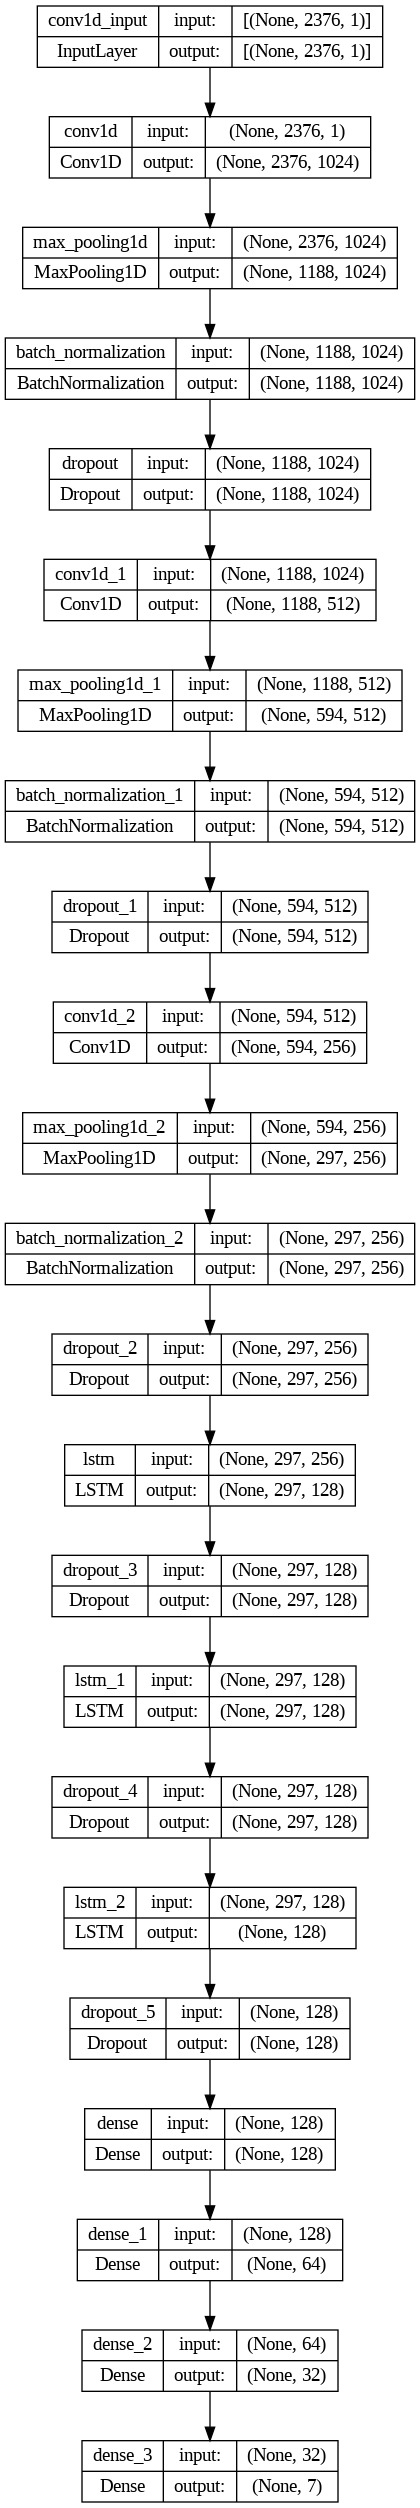

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model( model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
hist1=model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
72/72 [==============================] - 2516s 35s/step - loss: 1.8999 - accuracy: 0.1975 - val_loss: 1.9326 - val_accuracy: 0.2066
Epoch 2/100
50/72 [===================>..........] - ETA: 11:51 - loss: 1.8776 - accuracy: 0.2144

In [ ]:


# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('ser_cnn_lstm_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('/content/drive/MyDrive/ser_cnn_lstm_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2376, 1024)        6144      
                                                                 
 max_pooling1d (MaxPooling1  (None, 1188, 1024)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 1188, 1024)        4096      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1188, 1024)        0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1188, 512)         2621952   
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 594, 512)          0

36/36 [==============================] - 7s 84ms/step - loss: 0.8903 - accuracy: 0.7205
Accuracy of our model on test data :  72.04861044883728 %


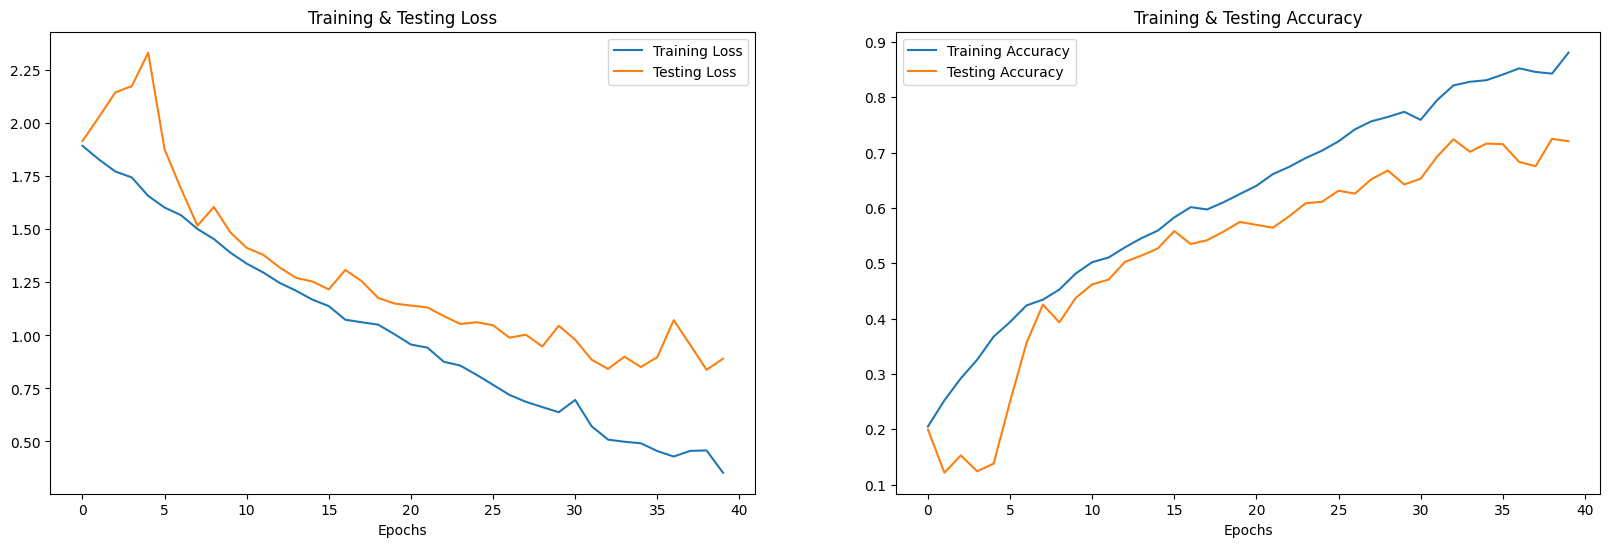

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")
epochs = [i for i in range(40)]
fig , ax = plt.subplots(1,2)
train_acc = hist1.history['accuracy']
train_loss = hist1.history['loss']
test_acc = hist1.history['val_accuracy']
test_loss = hist1.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred.flatten()
df0['Actual Labels'] = y_test.flatten()

df0.head(10)

36/36 [==============================] - 4s 81ms/step


,Predicted Labels,Actual Labels
0,happy,happy
1,sad,neutral
2,sad,sad
3,neutral,neutral
4,neutral,neutral
5,disgust,disgust
6,happy,happy
7,surprise,surprise
8,angry,angry
9,surprise,surprise


In [ ]:
x_test.shape

(1152, 1, 2376, 1)

# Evalutation

Results of best model

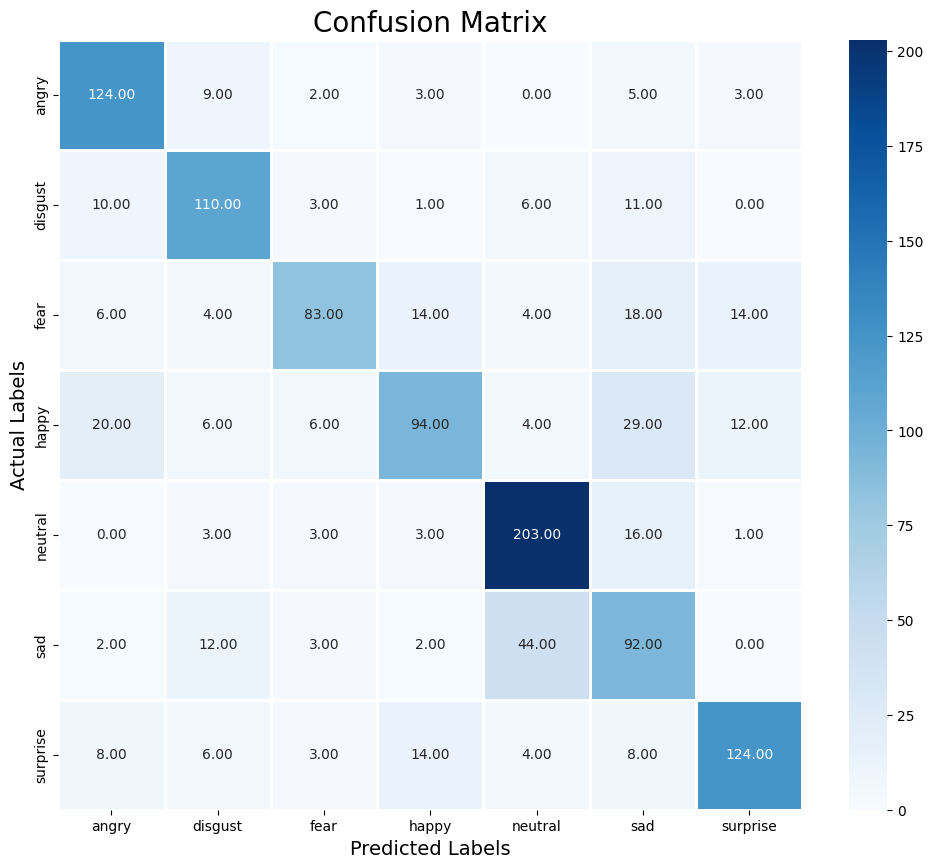

              precision    recall  f1-score   support

       angry       0.73      0.85      0.78       146
     disgust       0.73      0.78      0.76       141
        fear       0.81      0.58      0.67       143
       happy       0.72      0.55      0.62       171
     neutral       0.77      0.89      0.82       229
         sad       0.51      0.59      0.55       155
    surprise       0.81      0.74      0.77       167

    accuracy                           0.72      1152
   macro avg       0.72      0.71      0.71      1152
weighted avg       0.73      0.72      0.72      1152



In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test, y_pred))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = model.evaluate(x_test,y_test)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

36/36 [==============================] - 5s 84ms/step - loss: 0.8903 - accuracy: 0.7205
accuracy: 72.05%


pickle file


In [ ]:
import pickle

# Saving scaler
with open('scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)


print("Done")

Done


# Inference


In [ ]:
import pickle

with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)


print("Done")

Done


In [ ]:
import librosa

In [ ]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data):
    rmse=librosa.feature.rms(y=data)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

In [ ]:
def get_predict_feat(path):
    d, s_rate= librosa.load(path, duration=2.5, offset=0.6)
    res=extract_features(d)
    result=np.array(res)
    result=np.reshape(result,newshape=(1,2376))
    i_result = scaler2.transform(result)
    final_result=np.expand_dims(i_result, axis=2)

    return final_result

In [ ]:
res=get_predict_feat("/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/Actor_01/03-01-02-02-01-02-01.wav")
print(res.shape)

(1, 2376, 1)


In [ ]:
emotions1={1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust',8:'Surprise'}
def prediction(path1):
    res=get_predict_feat(path1)
    predictions=new_model.predict(res)
    y_pred = encoder2.inverse_transform(predictions)
    print(y_pred[0][0])

In [ ]:
prediction("/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/Actor_01/03-01-01-01-01-01-01.wav")

1/1 [==============================] - 0s 44ms/step
fear
